In [1]:
# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 50

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set path to the zip file
zip_path = '/content/drive/MyDrive/EmoSense.zip'  # Adjust path if needed

# Step 3: Extract the zip file
import zipfile
import os

# Optional: create target extraction folder
extract_to = '/content/EmoSense'
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete.


In [5]:
# ✅ Define paths
# Set base_dir to the extracted folder
base_dir = '/content/EmoSense'

# Define train and test directories inside the extracted dataset
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Optional: Confirm paths exist
print("Train directory:", train_dir)
print("Test directory:", test_dir)

# List some files to verify
print("\nSample files in train directory:")
print(os.listdir(train_dir)[:5])

print("\nSample files in test directory:")
print(os.listdir(test_dir)[:5])


Train directory: /content/EmoSense/train
Test directory: /content/EmoSense/test

Sample files in train directory:
['angry', 'neutral', 'sad', 'surprised', 'happy']

Sample files in test directory:
['angry', 'neutral', 'sad', 'surprised', 'happy']


In [6]:
# Image parameter
img_height, img_width = 48, 48
batch_size = 32
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Data augmentation and preprocessing for training
train_transforms = transforms.Compose([
    transforms.Grayscale(),  # Assuming grayscale images
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

# Only rescaling for testing
test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

In [8]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Get number of classes dynamically
num_classes = len(train_dataset.classes)
print(f"Detected {num_classes} classes: {train_dataset.classes}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Detected 7 classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [9]:
# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel for grayscale
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 128)  # 48x48 -> 6x6 after 3 pooling layers
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)  # Dynamic number of classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
# Initialize model, loss, and optimizer
model = EmotionCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-24-2119003320.py", line 12, in <cell line: 0>
    for images, labels in train_loader:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetc

TypeError: object of type 'NoneType' has no len()

In [12]:
# Save the model
torch.save(model.state_dict(), 'emotion_model.pth')
print("Model saved as 'emotion_model.pth')")

Model saved as 'emotion_model.pth')


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

              precision    recall  f1-score   support

       angry       0.50      0.38      0.43       958
   disgusted       1.00      0.01      0.02       111
     fearful       0.34      0.12      0.18      1024
       happy       0.74      0.83      0.79      1774
     neutral       0.42      0.68      0.52      1233
         sad       0.42      0.43      0.42      1247
   surprised       0.70      0.71      0.70       831

    accuracy                           0.55      7178
   macro avg       0.59      0.45      0.44      7178
weighted avg       0.54      0.55      0.52      7178



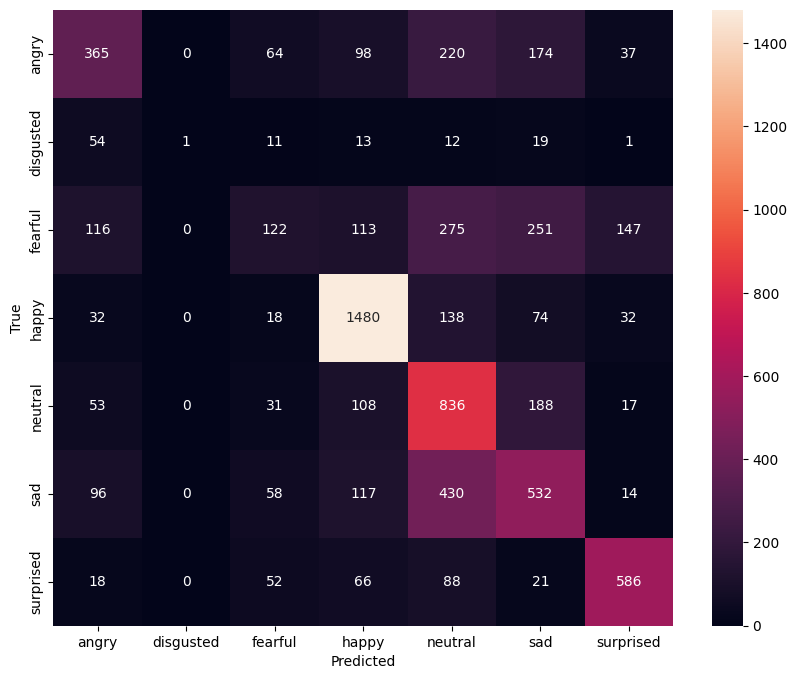

In [25]:
# Model Evaluation
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

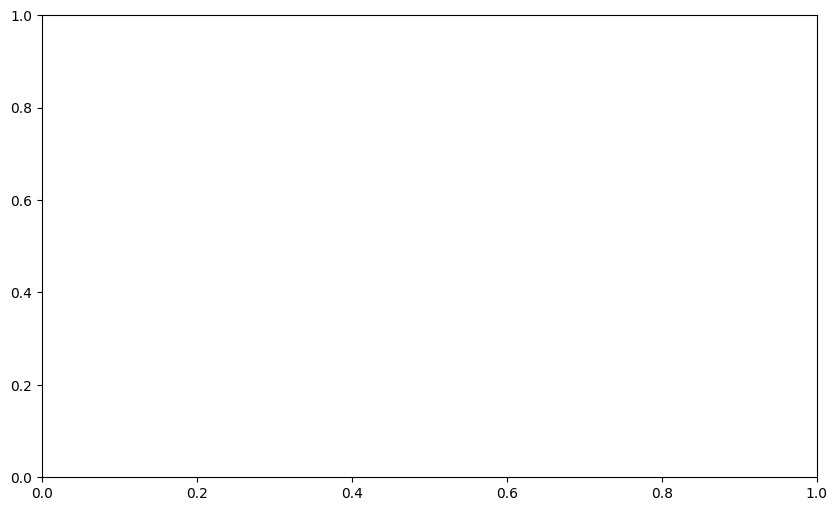

In [26]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()